In [1]:
import cv2
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort 
import openpifpaf as opp
from PIL import Image
import matplotlib.pyplot as plt
from deep_sort_realtime.deepsort_tracker import DeepSort
import pandas as pd
import numpy as np
from IPython.display import display
from ultralytics import YOLO
import torch
import seaborn as sns

## my funcitons
from utils.get_coordinates import get_yolov8_pose_track_coords
from utils.get_statistics import get_patterns
import utils.get_plots as pose_plots

import matplotlib.gridspec as gridspec

from sklearn.linear_model import LinearRegression
from plotnine import *

/home/alber/anaconda3/envs/masters_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YOLO("yolov8n-pose.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [3]:
video_path = "../inference/video/pannel_discussion_3_students.webm"

In [4]:
results = model.track(video_path,save=True,show=True,save_dir='./runs')



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/675) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/pannel_discussion_3_students.webm: 544x640 7 persons, 13.6ms
video 1/1 (frame 2/675) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/pannel_discussion_3_students.webm: 544x640 7 persons, 8.4ms
video 1/1 (frame 3/675) /home/alber/Desktop/DSB3/behavior-tracking-with-landmarks/src/../inference/video/pannel_discussion_3_

In [5]:
len(results) * 7 * 17

75089

## Funcs

In [6]:

import cv2
import numpy as np
import pandas as pd
import os


def get_yolov8_pose_track_coords(pose_result,save_dir,file_name):


    landmarks_list = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", 
             "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", 
             "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]

    landmark_body_part = {'nose': "face",
                     'left_eye': "face",
                     'right_eye': "face",
                     'left_ear': "face",
                     'right_ear': "face",
                     'left_shoulder':"upper_limbs",
                     'right_shoulder': "upper_limbs",
                     'left_elbow': "upper_limbs",
                     'right_elbow': "upper_limbs",
                     'left_wrist': "upper_limbs",
                     'right_wrist': "upper_limbs",
                     'left_hip': "lower_limbs",
                     'right_hip': "lower_limbs",
                     'left_knee': "lower_limbs",
                     'right_knee': "lower_limbs",
                     'left_ankle': "lower_limbs",
                     'right_ankle': "lower_limbs"}
    
    key_landmarks = {'nose': "nose",
                     'left_eye': "left_eye",
                     'right_eye': "right_eye",
                     'left_ear': "left_ear",
                     'right_ear': "right_ear",
                     'left_shoulder':"left_hand",
                     'right_shoulder': "right_hand",
                     'left_elbow': "left_hand",
                     'right_elbow': "right_hand",
                     'left_wrist': "left_hand",
                     'right_wrist': "right_hand",
                     'left_hip': "left_foot",
                     'right_hip': "right_foot",
                     'left_knee': "left_foot",
                     'right_knee': "right_foot",
                     'left_ankle': "left_foot",
                     'right_ankle': "right_foot"}
    
    key_landmarks_as_body_part = {
                                'nose': "face",
                                'left_eye': "face",
                                'right_eye': "face",
                                'left_ear': "face",
                                'right_ear': "face",
                                'left_shoulder':"left_hand",
                                'right_shoulder': "right_hand",
                                'left_elbow': "left_hand",
                                'right_elbow': "right_hand",
                                'left_wrist': "left_hand",
                                'right_wrist': "right_hand",
                                'left_hip': "left_foot",
                                'right_hip': "right_foot",
                                'left_knee': "left_foot",
                                'right_knee': "right_foot",
                                'left_ankle': "left_foot",
                                'right_ankle': "right_foot"}
    key_landmarks_as_body_part_2 = {
                                'nose': "face",
                                'left_eye': "face",
                                'right_eye': "face",
                                'left_ear': "face",
                                'right_ear': "face",
                                'left_shoulder':"hand",
                                'right_shoulder': "hand",
                                'left_elbow': "hand",
                                'right_elbow': "hand",
                                'left_wrist': "hand",
                                'right_wrist': "hand",
                                'left_hip': "foot",
                                'right_hip': "foot",
                                'left_knee': "foot",
                                'right_knee': "foot",
                                'left_ankle': "foot",
                                'right_ankle': "foot"}

    n_landmarks = len(landmarks_list)
    # cap = cv2.VideoCapture(video_path)

    n_frames = len(pose_result)

    # print(n_frames)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_color = (255, 0, 0)  
    thickness = 2
    
    
    full_cord_df = None
    
    
    dict_for_keypoints = {}
    
    for i_frame in range(n_frames):
    
    
        print(f"{'-'*30} FRAME {i_frame+1}/{n_frames} {'-'*30}")
        # plt.figure(figsize=(15,150))
    
    
        # get the frame
        result = pose_result[i_frame]
    
        orig_image = result.orig_img.copy() # get original image
        boxes = result.boxes # get bounding boxes
        keypoints = result.keypoints
    
        n_objects = len(result)
        
        for i_obj in range(n_objects):
    
            box = boxes[i_obj]
            keypoint = keypoints[i_obj]
    
            cls = int(box.cls.item())
            ID = int(box.id.item())
    
            box_x_min,box_y_min,box_x_max,box_y_max = box.xyxy.cpu().numpy()[0].astype(int)
    
            orig_image = cv2.rectangle(orig_image,(box_x_min,box_y_min),(box_x_max,box_y_max),(0,255,0),2)
            orig_image = cv2.putText(orig_image,"ID: "+str(ID),(box_x_min,box_y_min-5),font,font_scale,font_color,thickness)
    
            keypoint_coords = keypoint.xy.cpu().numpy()[0]
    
            # store keypoints in a dictionary to analyse movements
            # if id is not in the dict, add
    
            # id_dict_key = list(dict_for_keypoints.keys())
    
            # if ID not in id_dict_key:
    
                # print("Not")
                # print(landmarks_dict)
                # dict_for_keypoints[ID] = {landmarks_list[i]:[] for i in range(n_landmarks)}.copy()
                # dict_for_keypoints[ID] = copy.deepcopy(landmarks_dict)
            
    
            for pose_i in range(n_landmarks):
    
                pose = keypoint_coords[pose_i]
    
                landmark = landmarks_list[pose_i]
    
                pose_x,pose_y = pose.astype(int)
    
                # if landmarks appears or not
                lanmark_appears = False if  np.all(pose==np.array([0,0])) else True
    
                # dict_for_keypoints[ID][landmark].append([pose_x,pose_y])
    
    
                orig_image = cv2.circle(orig_image,(pose_x,pose_y),5,(0,0,255),-1)
    
                body_part = landmark_body_part[landmark]
                
                
                key_landmark = key_landmarks[landmark]
                key_landmark_as_body_part = key_landmarks_as_body_part[landmark]
                key_landmark_as_body_part_2 = key_landmarks_as_body_part_2[landmark]
    
                inner_df = pd.DataFrame({"Frame":[i_frame],
                                         "ID":[ID],
                                         "Landmark":[landmark],
                                         "LandmarkApears": [lanmark_appears],
                                         "BodyPart":[body_part],
                                         "RightLeftKeyLandmark":[key_landmark],
                                         "KeyLandmark" : [key_landmark_as_body_part],
                                         "KeyLandmarkFace":[key_landmark_as_body_part_2],
                                         "Pose_X":[pose_x],
                                         "Pose_Y":[pose_y],
                                         "bbox_x_min":[box_x_min],
                                         "bbox_y_min":[box_y_min],
                                         "bbox_x_max":[box_x_max],
                                         "bbox_y_max":[box_y_max]
                                        })
    
                if full_cord_df is None:
                    full_cord_df = inner_df.copy()
    
                    continue
    
                full_cord_df = pd.concat([full_cord_df,inner_df])


    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        # full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
        
    full_cord_df.to_csv(os.path.join(save_dir,file_name),index=False)
    
    return full_cord_df


def distance_between_keypoints(df,keypoints_1,keypoints_2,prefix="",col_name=None):
    
    try:
        keypoint_1 = keypoints_1[0].split("_")[1]
    except:
        keypoint_1 = 'face'
    keypoint_2 = keypoints_2[0].split("_")[1]
    
    data = df[['Frame','ID','Landmark','Pose_X','Pose_Y']].copy()
    
    df_1 = data[data['Landmark'].isin(keypoints_1)].drop("Landmark",axis=1)
    df_2 = data[data['Landmark'].isin(keypoints_2)].drop("Landmark",axis=1)
    
    df_1 = df_1.groupby(['ID','Frame']).agg("mean").add_prefix(keypoint_1+"_mean_")
    
    x_1,y_1 = df_1.columns
    df_1.reset_index(inplace=True)
    
    df_2 = df_2.groupby(['ID','Frame']).agg("mean").add_prefix(keypoint_2+"_mean_")
    
    
    x_2,y_2 = df_2.columns
    df_2.reset_index(inplace=True)
    
    df_1_2 = df_1.merge(df_2,on=['ID','Frame'])

    col_name = keypoint_1+"_to_"+prefix+keypoint_2 if col_name is None else col_name
    dist_1 = 'Euclidean_' + col_name
    dist_2 = 'Manhattan_' + col_name
    
    df_1_2[dist_1] = round(np.sqrt((df_1_2[x_2]-df_1_2[x_1])**2 + (df_1_2[y_2]-df_1_2[y_1])**2))
    df_1_2[dist_2] = round(abs(df_1_2[x_2]-df_1_2[x_1]) + abs(df_1_2[y_2]-df_1_2[y_1]))
    
    df_1_2_pc_change = df_1_2.groupby("ID")[[dist_1,dist_2]].pct_change().add_prefix("p_change_").fillna(0)
    pc_change_columns = df_1_2_pc_change.columns
    
    df_1_2 = df_1_2.reset_index().merge(df_1_2_pc_change.reset_index(),on='index').drop("index",axis=1)
    
    df_1_2 = df_1_2[['ID','Frame',dist_1,dist_2]+list(pc_change_columns)]

    return df_1_2


## Results

In [7]:
# df = pd.read_csv("./coord_data/yolov8_pose_tracking_discussion_2.csv")

# df = get_yolov8_pose_track_coords(results,save_dir='./coord_data/',file_name="panel_discussion_3.csv")
df = pd.read_csv("./coord_data/panel_discussion_3.csv")

# df['KeyLandmark'] = df['RightLeftKeyLandmark'].map({
#     'nose':'face',
#     'left_eye':'face',
#     'right_eye':'face',
#     'left_ear':'face', 
#     'right_ear':'face', 
#     'left_hand':'left_hand',
#     'right_hand':'right_hand',
#     'left_foot':'left_foot',
#     'right_foot':'right_foot'
# })
df_not_zero = df[df['LandmarkApears']]

In [8]:
orig_image_shape = (663, 826, 3)
df.shape

(75089, 14)

In [9]:
present_data = df[['Frame','ID','Landmark','Pose_X','Pose_Y','bbox_x_min','bbox_y_min','bbox_x_max','bbox_y_max']].copy()

In [10]:
present_data.rename(columns={
    old:new for old,new in zip(['Frame','ID','Landmark','Pose_X','Pose_Y','bbox_x_min','bbox_y_min','bbox_x_max','bbox_y_max'],
                              ['Frame ID','Person ID','Landmark','Pose X','Pose Y','BBox X min','BBox Y min','BBox X max','BBox Y max'])
},inplace=True)

In [11]:
present_data.head(10)

,Frame ID,Person ID,Landmark,Pose X,Pose Y,BBox X min,BBox Y min,BBox X max,BBox Y max
0,0,1,nose,344,286,288,248,409,524
1,0,1,left_eye,351,281,288,248,409,524
2,0,1,right_eye,337,279,288,248,409,524
3,0,1,left_ear,359,285,288,248,409,524
4,0,1,right_ear,324,282,288,248,409,524
5,0,1,left_shoulder,364,319,288,248,409,524
6,0,1,right_shoulder,306,318,288,248,409,524
7,0,1,left_elbow,373,371,288,248,409,524
8,0,1,right_elbow,303,376,288,248,409,524
9,0,1,left_wrist,369,392,288,248,409,524


## Calculations

In [12]:
# mean poses
# total mean pose coordinate for each id in each frame 
df_mean_poses = df_not_zero.groupby(['ID','Frame'])[['Pose_X','Pose_Y']].mean().add_prefix("Total_Mean_")
df_mean_pc_change = df_mean_poses.pct_change().add_prefix("pc_").reset_index().fillna(0)
df_mean_poses = df_mean_poses.reset_index().merge(df_mean_pc_change,on=['ID','Frame'])

key_parts = df_not_zero['KeyLandmarkFace'].unique()


# there are three main parts, face, hands and feet
# here is the calculation of means for each keypoint
for key in key_parts:
    
    df_mean_poses_parts = df_not_zero[df_not_zero['KeyLandmarkFace']==key].groupby(['ID','Frame'])[['Pose_X','Pose_Y']].mean().add_prefix(key+"_Mean")
    # break
    df_mean_poses_parts_pc = df_mean_poses_parts.pct_change().add_prefix("pc_").reset_index().fillna(0)
    df_mean_poses_parts = df_mean_poses_parts.reset_index().merge(df_mean_poses_parts_pc,on=['ID','Frame'])
    
    df_mean_poses = df_mean_poses.merge(df_mean_poses_parts,on=['ID','Frame'])


# mean bboxes
# bounding boxes can tell lots about an id 

bbox_cols = ['bbox_x_min','bbox_y_min','bbox_x_max','bbox_y_max']
df_bbox = df_not_zero[['Frame','ID']+bbox_cols].copy().drop_duplicates()

# # area
df_bbox['bbox_width'] = df_bbox['bbox_x_max']-df_bbox['bbox_x_min']
df_bbox['bbox_height'] = df_bbox['bbox_y_max']-df_bbox['bbox_y_min']
df_bbox['bbox_center_x'] = (df_bbox['bbox_width']/2).astype(int)
df_bbox['bbox_center_y'] = (df_bbox['bbox_height']/2).astype(int)
df_bbox['bbox_area'] = df_bbox['bbox_width']*df_bbox['bbox_height']
df_bbox_pc = df_bbox.drop("Frame",axis=1).groupby("ID").agg("pct_change").add_prefix("p_change")
df_bbox_pc.fillna(0,inplace=True)
df_bbox = df_bbox.reset_index().merge(df_bbox_pc.reset_index(),on='index').drop("index",axis=1)
df_bbox = df_bbox[['ID','Frame','bbox_center_x','bbox_center_y','bbox_area',\
                       'p_changebbox_center_x', 'p_changebbox_center_y','p_changebbox_area']]

individul_metrics_df = df_mean_poses.merge(df_bbox,on=['ID','Frame'])


# also, we can calculate some distances between any keypoints
keypoints_1 = ['left_eye', 'right_eye']
keypoints_2 = ['left_shoulder', 'right_shoulder']

eye_shoulder_distance =  distance_between_keypoints(df_not_zero,keypoints_1,keypoints_2)

# nose to left and right shoulders

nose_to_left_shoulder_distance =  distance_between_keypoints(df_not_zero,['nose'],['left_shoulder'],col_name='nose_to_left_shoulder')
nose_to_right_shoulder_distance =  distance_between_keypoints(df_not_zero,['nose'],['right_shoulder'],col_name='nose_to_right_shoulder')


keypoints_1 = ['nose', 'left_eye', 'right_eye', 'right_ear','left_ear']
keypoints_2 = ['left_elbow','left_wrist']


face_to_left_hand_distance = distance_between_keypoints(df_not_zero,keypoints_1,keypoints_2,prefix='left',col_name='face_to_left_hand')


keypoints_1 = ['nose', 'left_eye', 'right_eye', 'right_ear','left_ear']
keypoints_2 = ['right_elbow','right_wrist']

face_to_right_hand_distance = distance_between_keypoints(df_not_zero,keypoints_1,keypoints_2,prefix='right',col_name='face_to_right_hand')


# keypoints_1 = ['left_eye', 'right_eye']
# keypoints_2 = ['left_shoulder', 'right_shoulder']

keypoints_1 = ['nose', 'left_eye', 'right_eye', 'right_ear','left_ear']
keypoints_2 = ['left_ankle','right_ankle']

face_to_ankle_distance = distance_between_keypoints(df_not_zero,keypoints_1,keypoints_2,col_name='face_to_ankle')



individul_metrics_df = individul_metrics_df.merge(eye_shoulder_distance,on=['ID','Frame'])
individul_metrics_df = individul_metrics_df.merge(face_to_left_hand_distance,on=['ID','Frame'])
individul_metrics_df = individul_metrics_df.merge(face_to_right_hand_distance,on=['ID','Frame'])
individul_metrics_df = individul_metrics_df.merge(face_to_ankle_distance,on=['ID','Frame'])
individul_metrics_df = individul_metrics_df.merge(nose_to_left_shoulder_distance,on=['ID','Frame'])
individul_metrics_df = individul_metrics_df.merge(nose_to_right_shoulder_distance,on=['ID','Frame'])



# appearce of body part
KeyLandmark = df_not_zero.KeyLandmark.unique()

key_lanrmark_counts = {"face":5,"left_hand":3,"right_hand":3,"left_foot":3,"right_foot":3}

for key in KeyLandmark:

    key_df = df_not_zero[df_not_zero['KeyLandmark'] == key].copy()
    key_df = key_df.groupby(['Frame','ID'])['KeyLandmark'].count().to_frame().rename(columns={"KeyLandmark":"Actual"}).reset_index()
    count = key_lanrmark_counts[key]
    key_df['Real'] = count
    col_name = key+'_AppearanceRate'
    key_df[col_name] = key_df['Actual']/key_df['Real']
    key_df = key_df[['ID','Frame',col_name]]
    individul_metrics_df = individul_metrics_df.merge(key_df,on=['ID','Frame'])

### Full plots

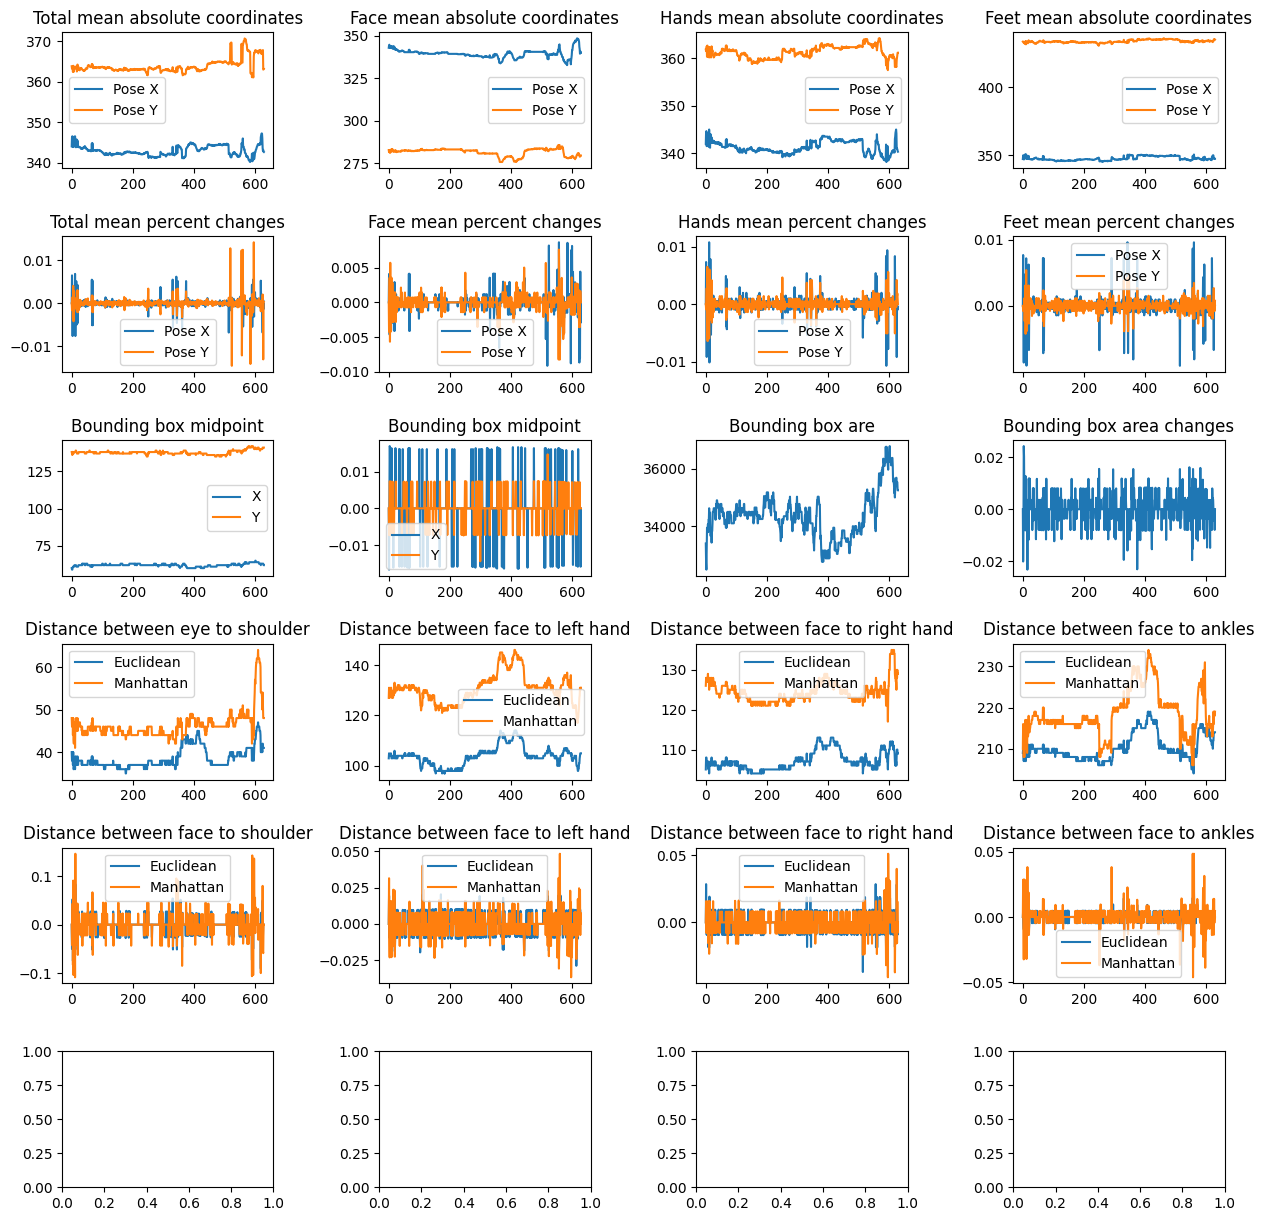

In [13]:
ids = individul_metrics_df.ID.unique()

for ID in ids:

    id_df = individul_metrics_df[individul_metrics_df['ID'] == ID]

    # correlation 
    corr_change_pose_x_df = id_df[['pc_Total_Mean_Pose_X','pc_face_MeanPose_X','pc_hand_MeanPose_X','pc_foot_MeanPose_X']].copy().\
                         rename(columns={'pc_Total_Mean_Pose_X':'Total mean',
                                         'pc_face_MeanPose_X':'Face',
                                         'pc_hand_MeanPose_X':'Hands',
                                         'pc_foot_MeanPose_X':"Feet"})
    corr_change_pose_x = corr_change_pose_x_df.corr()
    
    corr_change_pose_y_df = id_df[['pc_Total_Mean_Pose_Y','pc_face_MeanPose_Y','pc_hand_MeanPose_Y','pc_foot_MeanPose_Y']].copy().\
                        rename(columns={'pc_Total_Mean_Pose_Y':'Total mean',
                                        'pc_face_MeanPose_Y':'Face',
                                        'pc_hand_MeanPose_Y':'Hands',
                                        'pc_foot_MeanPose_Y':"Feet"})
    
    corr_change_pose_y = corr_change_pose_y_df.corr()

    
    fig,ax = plt.subplots(6,4)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.subplots_adjust(wspace=0.5,hspace=.5)  # Adjust the value as needed
    axes = ax.flatten()
    
    axes[0].plot(id_df['Frame'],id_df['Total_Mean_Pose_X'],label='Pose X')
    axes[0].plot(id_df['Frame'],id_df['Total_Mean_Pose_Y'],label='Pose Y')
    axes[0].set_title("Total mean absolute coordinates")
    axes[0].legend()

    axes[1].plot(id_df['Frame'],id_df['face_MeanPose_X'],label='Pose X')
    axes[1].plot(id_df['Frame'],id_df['face_MeanPose_Y'],label='Pose Y')
    axes[1].set_title("Face mean absolute coordinates")
    axes[1].legend()


    axes[2].plot(id_df['Frame'],id_df['hand_MeanPose_X'],label='Pose X')
    axes[2].plot(id_df['Frame'],id_df['hand_MeanPose_Y'],label='Pose Y')
    axes[2].set_title("Hands mean absolute coordinates")
    axes[2].legend()


    axes[3].plot(id_df['Frame'],id_df['foot_MeanPose_X'],label='Pose X')
    axes[3].plot(id_df['Frame'],id_df['foot_MeanPose_Y'],label='Pose Y')
    axes[3].set_title("Feet mean absolute coordinates")
    axes[3].legend()

    axes[4].plot(id_df['Frame'],id_df['pc_Total_Mean_Pose_X'],label='Pose X')
    axes[4].plot(id_df['Frame'],id_df['pc_Total_Mean_Pose_Y'],label='Pose Y')
    axes[4].set_title("Total mean percent changes")
    axes[4].legend()

    axes[5].plot(id_df['Frame'],id_df['pc_face_MeanPose_X'],label='Pose X')
    axes[5].plot(id_df['Frame'],id_df['pc_face_MeanPose_Y'],label='Pose Y')
    axes[5].set_title("Face mean percent changes")
    axes[5].legend()


    axes[6].plot(id_df['Frame'],id_df['pc_hand_MeanPose_X'],label='Pose X')
    axes[6].plot(id_df['Frame'],id_df['pc_hand_MeanPose_Y'],label='Pose Y')
    axes[6].set_title("Hands mean percent changes")
    axes[6].legend()


    axes[7].plot(id_df['Frame'],id_df['pc_foot_MeanPose_X'],label='Pose X')
    axes[7].plot(id_df['Frame'],id_df['pc_foot_MeanPose_Y'],label='Pose Y')
    axes[7].set_title("Feet mean percent changes")
    axes[7].legend()

    # bbox_center_x 	bbox_center_y 	bbox_area 	p_changebbox_center_x 	p_changebbox_center_y 	p_changebbox_area
    axes[8].plot(id_df['Frame'],id_df['bbox_center_x'],label='X')
    axes[8].plot(id_df['Frame'],id_df['bbox_center_y'],label='Y')
    axes[8].set_title("Bounding box midpoint")
    axes[8].legend()



    axes[9].plot(id_df['Frame'],id_df['p_changebbox_center_x'],label='X')
    axes[9].plot(id_df['Frame'],id_df['p_changebbox_center_y'],label='Y')
    axes[9].set_title("Bounding box midpoint")
    axes[9].legend()

    axes[10].plot(id_df['Frame'],id_df['bbox_area'])
    axes[10].set_title("Bounding box are")

    axes[11].plot(id_df['Frame'],id_df['p_changebbox_area'])
    axes[11].set_title("Bounding box area changes")


       # 'Euclidean_eye_to_shoulder', 'Manhattan_eye_to_shoulder',
    
       # 'p_change_Euclidean_eye_to_shoulder',
       # 'p_change_Manhattan_eye_to_shoulder', 
       # 
       # 'Euclidean_face_to_left_hand',
       # 'Manhattan_face_to_left_hand', 'p_change_Euclidean_face_to_left_hand',
       # 'p_change_Manhattan_face_to_left_hand', 
    
       # 'Euclidean_face_to_right_hand',
       # 'Manhattan_face_to_right_hand', 'p_change_Euclidean_face_to_right_hand',
       # 'p_change_Manhattan_face_to_right_hand', 'Euclidean_face_to_ankle',
       # 'Manhattan_face_to_ankle', 'p_change_Euclidean_face_to_ankle',
       # 'p_change_Manhattan_face_to_ankle', 'Euclidean_nose_to_left_shoulder',
       # 'Manhattan_nose_to_left_shoulder',
       # 'p_change_Euclidean_nose_to_left_shoulder',
       # 'p_change_Manhattan_nose_to_left_shoulder',
       # 'Euclidean_nose_to_right_shoulder', 'Manhattan_nose_to_right_shoulder',
       # 'p_change_Euclidean_nose_to_right_shoulder',
       # 'p_change_Manhattan_nose_to_right_shoulder',
    
    axes[12].plot(id_df['Frame'],id_df['Euclidean_eye_to_shoulder'],label='Euclidean')
    axes[12].plot(id_df['Frame'],id_df['Manhattan_eye_to_shoulder'],label='Manhattan')
    axes[12].set_title("Distance between eye to shoulder")
    axes[12].legend()

    axes[13].plot(id_df['Frame'],id_df['Euclidean_face_to_left_hand'],label='Euclidean')
    axes[13].plot(id_df['Frame'],id_df['Manhattan_face_to_left_hand'],label='Manhattan')
    axes[13].set_title("Distance between face to left hand")
    axes[13].legend()

    axes[14].plot(id_df['Frame'],id_df['Euclidean_face_to_right_hand'],label='Euclidean')
    axes[14].plot(id_df['Frame'],id_df['Manhattan_face_to_right_hand'],label='Manhattan')
    axes[14].set_title("Distance between face to right hand")
    axes[14].legend()

    axes[15].plot(id_df['Frame'],id_df['Euclidean_face_to_ankle'],label='Euclidean')
    axes[15].plot(id_df['Frame'],id_df['Manhattan_face_to_ankle'],label='Manhattan')
    axes[15].set_title("Distance between face to ankles")
    axes[15].legend()

    axes[16].plot(id_df['Frame'],id_df['p_change_Euclidean_eye_to_shoulder'],label='Euclidean')
    axes[16].plot(id_df['Frame'],id_df['p_change_Manhattan_eye_to_shoulder'],label='Manhattan')
    axes[16].set_title("Distance between face to shoulder")
    axes[16].legend()

    axes[17].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_left_hand'],label='Euclidean')
    axes[17].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_left_hand'],label='Manhattan')
    axes[17].set_title("Distance between face to left hand")
    axes[17].legend()

    axes[18].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_right_hand'],label='Euclidean')
    axes[18].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_right_hand'],label='Manhattan')
    axes[18].set_title("Distance between face to right hand")
    axes[18].legend()

    axes[19].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_ankle'],label='Euclidean')
    axes[19].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_ankle'],label='Manhattan')
    axes[19].set_title("Distance between face to ankles")
    axes[19].legend()

    # face_AppearanceRate 	left_hand_AppearanceRate 	right_hand_AppearanceRate 	left_foot_AppearanceRate 	right_foot_AppearanceRate


    # plt.figure(figsize=(15,15))
    # plt.plot(id_df['Frame'],id_df['face_AppearanceRate'])
    # plt.plot(id_df['Frame'],id_df['left_hand_AppearanceRate'])
    # plt.plot(id_df['Frame'],id_df['right_hand_AppearanceRate'])
    # plt.plot(id_df['Frame'],id_df['left_foot_AppearanceRate'])
    # plt.plot(id_df['Frame'],id_df['right_foot_AppearanceRate'])
        
    
    
    break

## Part 1: Poses

### Figure 5. Absolute values of keypoints mean coordinates for each frame

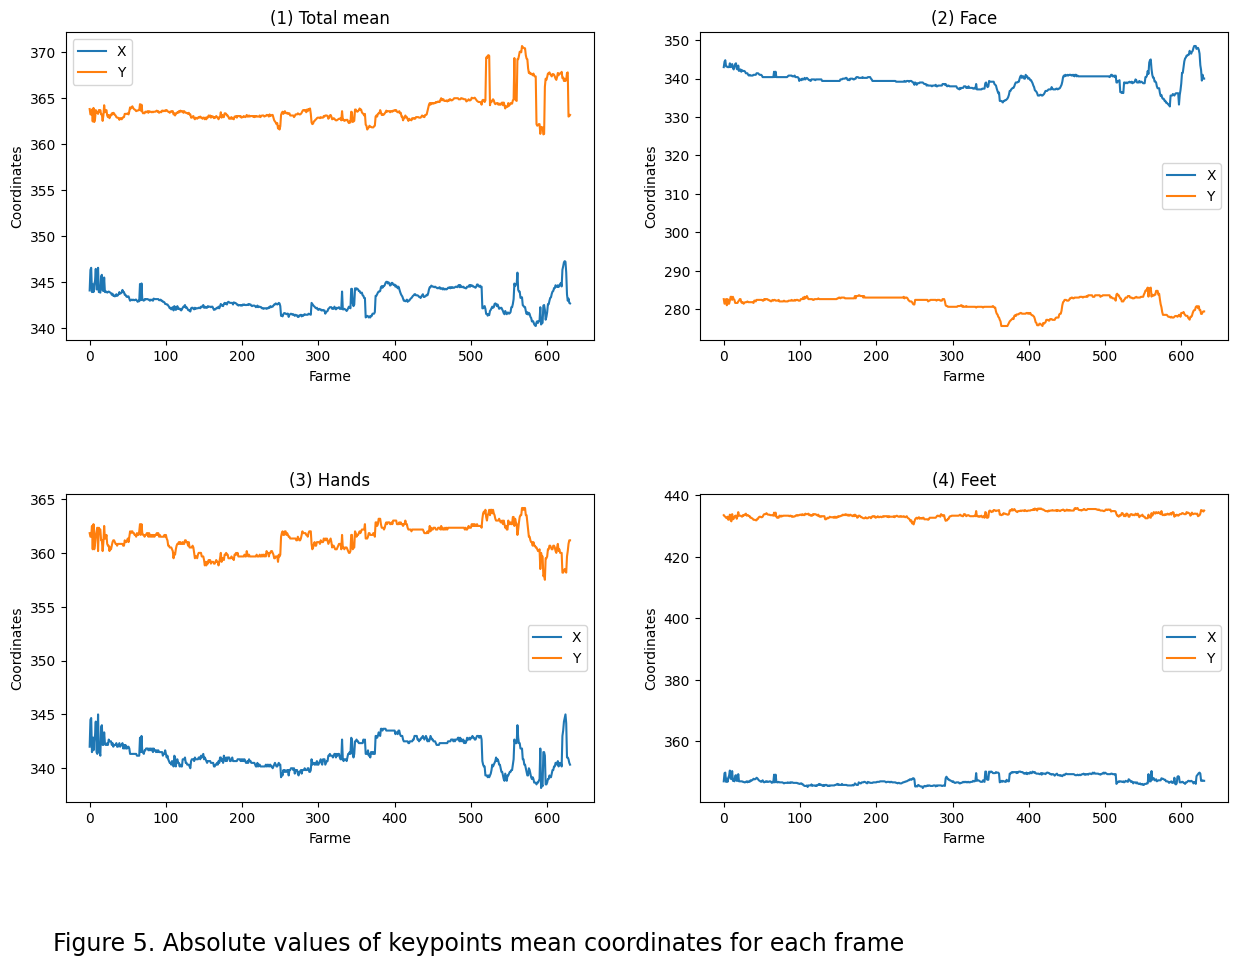

In [14]:

print()
print()
fig,ax = plt.subplots(2,2)



fig.set_figwidth(15)
fig.set_figheight(10)
fig.subplots_adjust(hspace=.5)
# fig.suptitle("Figure 2. Absolute values of keypoints mean coordinates during video")
fig.suptitle("Figure 5. Absolute values of keypoints mean coordinates for each frame",fontsize=17, x=0.4, y=-.02, ha='center')

axes = ax.flatten()


x_y_title = [['Total_Mean_Pose_X','Total_Mean_Pose_Y','Total mean'],
             ['face_MeanPose_X','face_MeanPose_Y','Face'],
             ['hand_MeanPose_X','hand_MeanPose_Y','Hands'],
             ['foot_MeanPose_X','foot_MeanPose_Y','Feet']]


for i,param in enumerate(x_y_title):

    pose_x,pose_y,title = param

    
    axes[i].plot(id_df['Frame'],id_df[pose_x],label='X')
    axes[i].plot(id_df['Frame'],id_df[pose_y],label='Y')
    axes[i].set_title("(" + str(i+1) + ") " + title)
    axes[i].set_xlabel("Farme")
    axes[i].set_ylabel("Coordinates")
    axes[i].legend()


plt.show()

### Figure 6. Percent change of keypoints mean coordinates for each frame

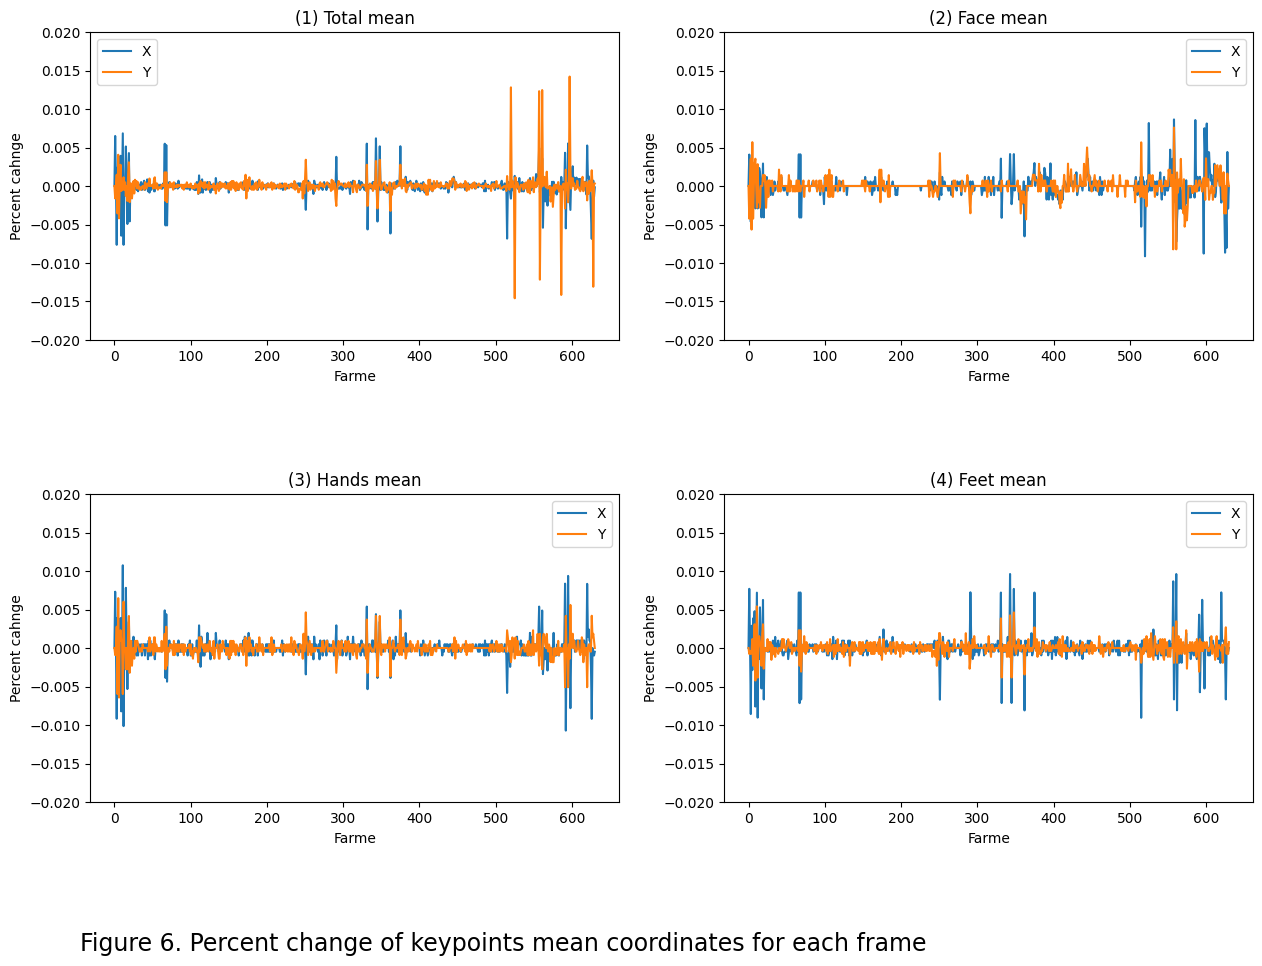

In [15]:
fig,ax = plt.subplots(2,2)


print()
print()
print()
fig.set_figwidth(15)
fig.set_figheight(10)
fig.subplots_adjust(hspace=.5)
fig.suptitle("Figure 6. Percent change of keypoints mean coordinates for each frame",fontsize=17, x=0.4, y=-.02, ha='center')

# fig.suptitle("Figure 3. Percent change of keypoints mean coordinates changes during video")
axes = ax.flatten()


x_y_title = [['pc_Total_Mean_Pose_X','pc_Total_Mean_Pose_Y','Total mean'],
             ['pc_face_MeanPose_X','pc_face_MeanPose_Y','Face mean'],
             ['pc_hand_MeanPose_X','pc_hand_MeanPose_Y','Hands mean'],
             ['pc_foot_MeanPose_X','pc_foot_MeanPose_Y','Feet mean']]


for i,param in enumerate(x_y_title):

    pose_x,pose_y,title = param

    
    axes[i].plot(id_df['Frame'],id_df[pose_x],label='X')
    axes[i].plot(id_df['Frame'],id_df[pose_y],label='Y')
    axes[i].set_title("(" + str(i+1) + ") " + title)
    axes[i].set_xlabel("Farme")
    axes[i].set_ylabel("Percent cahnge")
    axes[i].legend()
    axes[i].set_ylim(-.02,.02)


plt.show()

### Figure 7. Correlation between percent changes

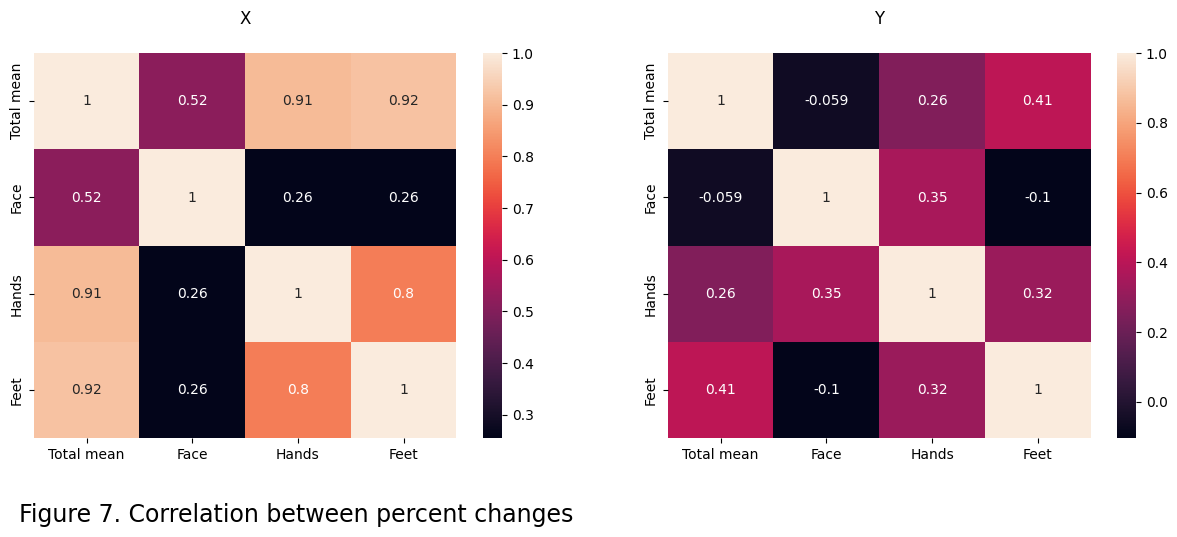

In [16]:
fig,ax = plt.subplots(1,2)


print()
print()
fig.set_figwidth(15)
fig.set_figheight(5)

# fig.suptitle("Figure 4. Correlation between percent changes")
fig.suptitle("Figure 7. Correlation between percent changes",fontsize=17, x=0.3,y=-.02, ha='center')

sns.heatmap(corr_change_pose_x,annot=True,ax=ax[0])
ax[0].set_title("X\n")

sns.heatmap(corr_change_pose_y,annot=True,ax=ax[1])
ax[1].set_title("Y\n")


plt.show()

### Figure 8. Metrics calculated using min and max values of x and y coordinates of bounding box

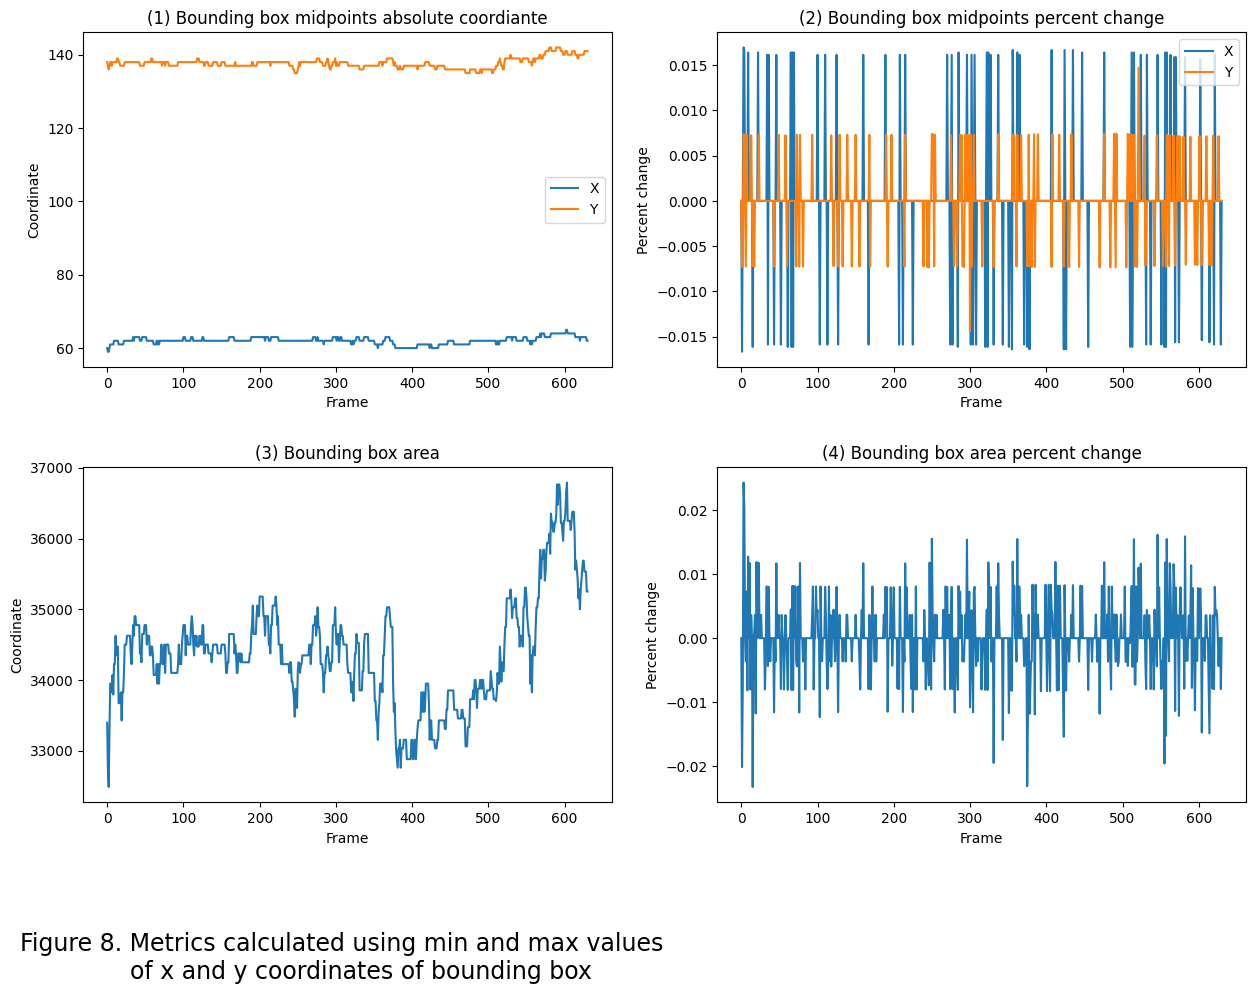

In [17]:
print()
print()


fig,ax = plt.subplots(2,2)

fig.set_figheight(10)
fig.set_figwidth(15)

fig.subplots_adjust(hspace=.3)
axes = ax.flatten()

axes[0].plot(id_df['Frame'],id_df['bbox_center_x'],label='X')
axes[0].plot(id_df['Frame'],id_df['bbox_center_y'],label='Y')
axes[0].set_title("(1) Bounding box midpoints absolute coordiante")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Coordinate")


axes[1].plot(id_df['Frame'],id_df['p_changebbox_center_x'],label='X')
axes[1].plot(id_df['Frame'],id_df['p_changebbox_center_y'],label='Y')
axes[1].set_title("(2) Bounding box midpoints percent change")
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Percent change")
axes[1].legend()

axes[2].plot(id_df['Frame'],id_df['bbox_area'])
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Coordinate")
axes[2].set_title("(3) Bounding box area")


axes[3].plot(id_df['Frame'],id_df['p_changebbox_area'])
axes[3].set_title("(4) Bounding box area percent change")
axes[3].set_xlabel("Frame")
axes[3].set_ylabel("Percent change")
fig.suptitle("Figure 8. Metrics calculated using min and max values \n    of x and y coordinates of bounding box",fontsize=17, x=0.3,y=-.02, ha='center')

plt.show()

## Part 2 & 3 Distances and freq

In [18]:
distance_df = id_df[['ID','Frame','Euclidean_eye_to_shoulder', 'Manhattan_eye_to_shoulder',
       'p_change_Euclidean_eye_to_shoulder',
       'p_change_Manhattan_eye_to_shoulder', 'Euclidean_face_to_left_hand',
       'Manhattan_face_to_left_hand', 'p_change_Euclidean_face_to_left_hand',
       'p_change_Manhattan_face_to_left_hand', 'Euclidean_face_to_right_hand',
       'Manhattan_face_to_right_hand', 'p_change_Euclidean_face_to_right_hand',
       'p_change_Manhattan_face_to_right_hand', 'Euclidean_face_to_ankle',
       'Manhattan_face_to_ankle', 'p_change_Euclidean_face_to_ankle',
       'p_change_Manhattan_face_to_ankle', 'Euclidean_nose_to_left_shoulder',
       'Manhattan_nose_to_left_shoulder',
       'p_change_Euclidean_nose_to_left_shoulder',
       'p_change_Manhattan_nose_to_left_shoulder',
       'Euclidean_nose_to_right_shoulder', 'Manhattan_nose_to_right_shoulder',
       'p_change_Euclidean_nose_to_right_shoulder',
       'p_change_Manhattan_nose_to_right_shoulder']].copy()

### Figure 9. Distance between eyes to shoulders

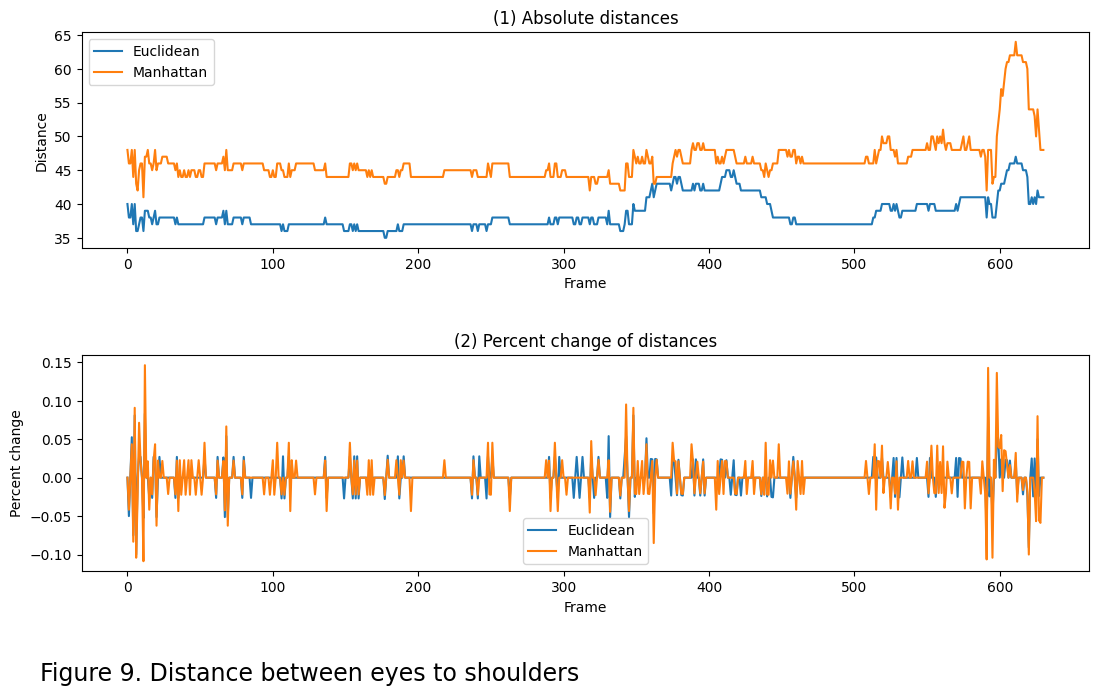

In [19]:
fig,ax = plt.subplots(2,1)


print()
print()
fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 9. Distance between eyes to shoulders',fontsize=17, x=0.3,y=-.02, ha='center')
fig.subplots_adjust(hspace=.5)
axes[0].plot(id_df['Frame'],id_df['Euclidean_eye_to_shoulder'],label='Euclidean')
axes[0].plot(id_df['Frame'],id_df['Manhattan_eye_to_shoulder'],label='Manhattan')
axes[0].set_title("(1) Absolute distances")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(id_df['Frame'],id_df['p_change_Euclidean_eye_to_shoulder'],label='Euclidean')
axes[1].plot(id_df['Frame'],id_df['p_change_Manhattan_eye_to_shoulder'],label='Manhattan')
axes[1].set_title("(2) Percent change of distances")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Percent change")




plt.show()


### Figure 10. Distance between nose and left/right shoulders

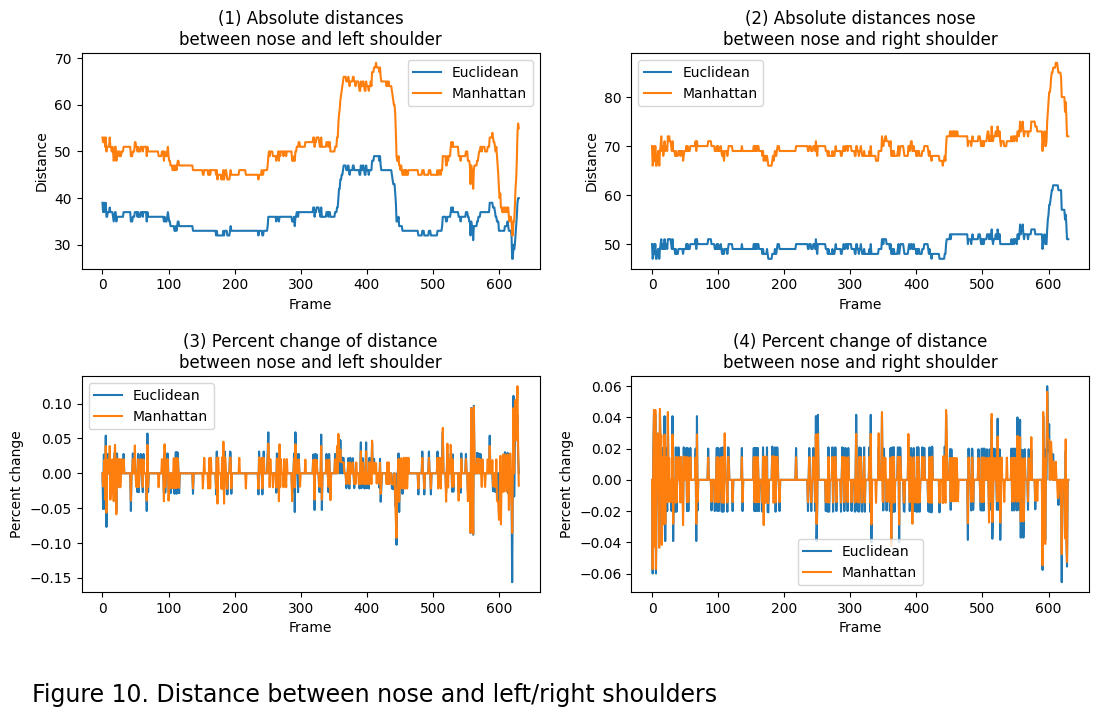

In [20]:
# Euclidean_nose_to_left_shoulder, Manhattan_nose_to_left_shoulder,
# Euclidean_nose_to_right_shoulder, Manhattan_nose_to_right_shoulder

# p_change_Euclidean_nose_to_left_shoulder, p_change_Manhattan_nose_to_left_shoulder
# p_change_Euclidean_nose_to_right_shoulder, p_change_Manhattan_nose_to_right_shoulder
print()
print()
fig,ax = plt.subplots(2,2)


fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 10. Distance between nose and left/right shoulders',fontsize=17, x=0.35,y=-.02, ha='center')
fig.subplots_adjust(hspace=.5)


axes[0].plot(id_df['Frame'],id_df['Euclidean_nose_to_left_shoulder'],label='Euclidean')
axes[0].plot(id_df['Frame'],id_df['Manhattan_nose_to_left_shoulder'],label='Manhattan')
axes[0].set_title("(1) Absolute distances\nbetween nose and left shoulder")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(id_df['Frame'],id_df['Euclidean_nose_to_right_shoulder'],label='Euclidean')
axes[1].plot(id_df['Frame'],id_df['Manhattan_nose_to_right_shoulder'],label='Manhattan')
axes[1].set_title("(2) Absolute distances nose\nbetween nose and right shoulder")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Distance")


axes[2].plot(id_df['Frame'],id_df['p_change_Euclidean_nose_to_left_shoulder'],label='Euclidean')
axes[2].plot(id_df['Frame'],id_df['p_change_Manhattan_nose_to_left_shoulder'],label='Manhattan')
axes[2].set_title("(3) Percent change of distance\nbetween nose and left shoulder")
axes[2].legend()
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Percent change")


axes[3].plot(id_df['Frame'],id_df['p_change_Euclidean_nose_to_right_shoulder'],label='Euclidean')
axes[3].plot(id_df['Frame'],id_df['p_change_Manhattan_nose_to_right_shoulder'],label='Manhattan')
axes[3].set_title("(4) Percent change of distance\nbetween nose and right shoulder")
axes[3].legend()
axes[3].set_xlabel("Frame")
axes[3].set_ylabel("Percent change")



plt.show()


### Figure 11. Distance between face and left/right hands (elbow and wrist)

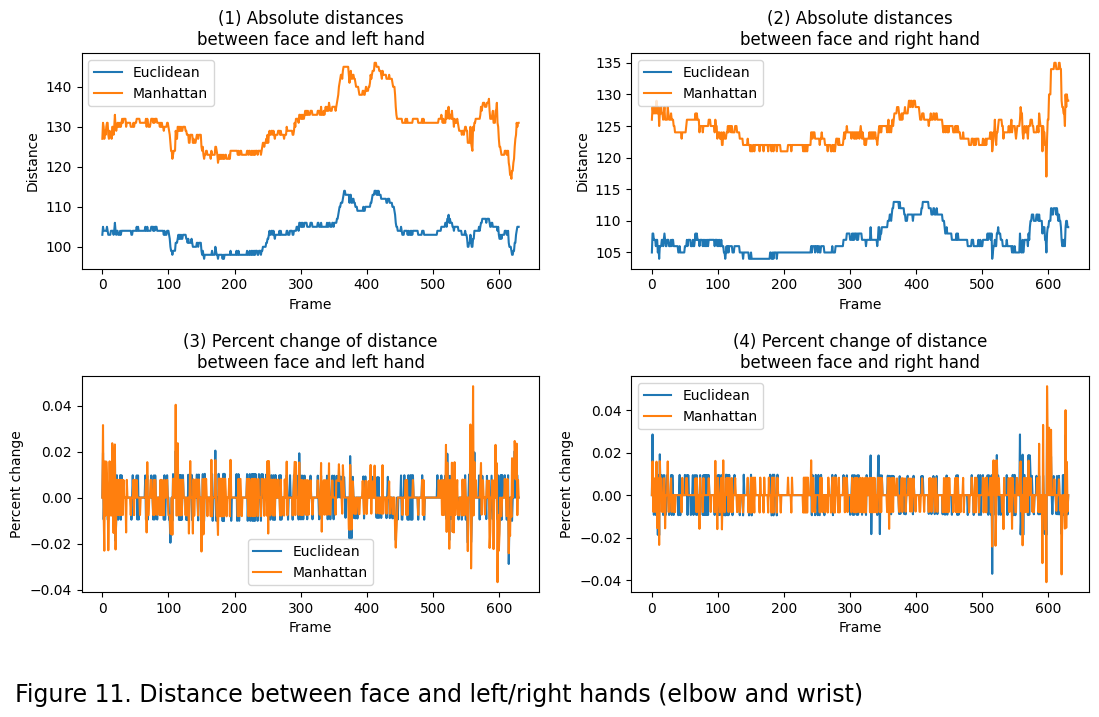

In [21]:
#'Euclidean_face_to_left_hand',
#'Manhattan_face_to_left_hand', 
# 'p_change_Euclidean_face_to_left_hand',
#'p_change_Manhattan_face_to_left_hand', 

# 'Euclidean_face_to_right_hand',
#' Manhattan_face_to_right_hand', 
# 'p_change_Euclidean_face_to_right_hand',
#'p_change_Manhattan_face_to_right_hand',


print()
print()
fig,ax = plt.subplots(2,2)


fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 11. Distance between face and left/right hands (elbow and wrist)',fontsize=17, x=0.4,y=-.02, ha='center')
fig.subplots_adjust(hspace=.5)


axes[0].plot(id_df['Frame'],id_df['Euclidean_face_to_left_hand'],label='Euclidean')
axes[0].plot(id_df['Frame'],id_df['Manhattan_face_to_left_hand'],label='Manhattan')
axes[0].set_title("(1) Absolute distances\nbetween face and left hand")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(id_df['Frame'],id_df['Euclidean_face_to_right_hand'],label='Euclidean')
axes[1].plot(id_df['Frame'],id_df['Manhattan_face_to_right_hand'],label='Manhattan')
axes[1].set_title("(2) Absolute distances\nbetween face and right hand")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Distance")


axes[2].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_left_hand'],label='Euclidean')
axes[2].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_left_hand'],label='Manhattan')
axes[2].set_title("(3) Percent change of distance\nbetween face and left hand")
axes[2].legend()
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Percent change")


axes[3].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_right_hand'],label='Euclidean')
axes[3].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_right_hand'],label='Manhattan')
axes[3].set_title("(4) Percent change of distance\nbetween face and right hand")
axes[3].legend()
axes[3].set_xlabel("Frame")
axes[3].set_ylabel("Percent change")



plt.show()


### Figure 12. Distance between face and ankles

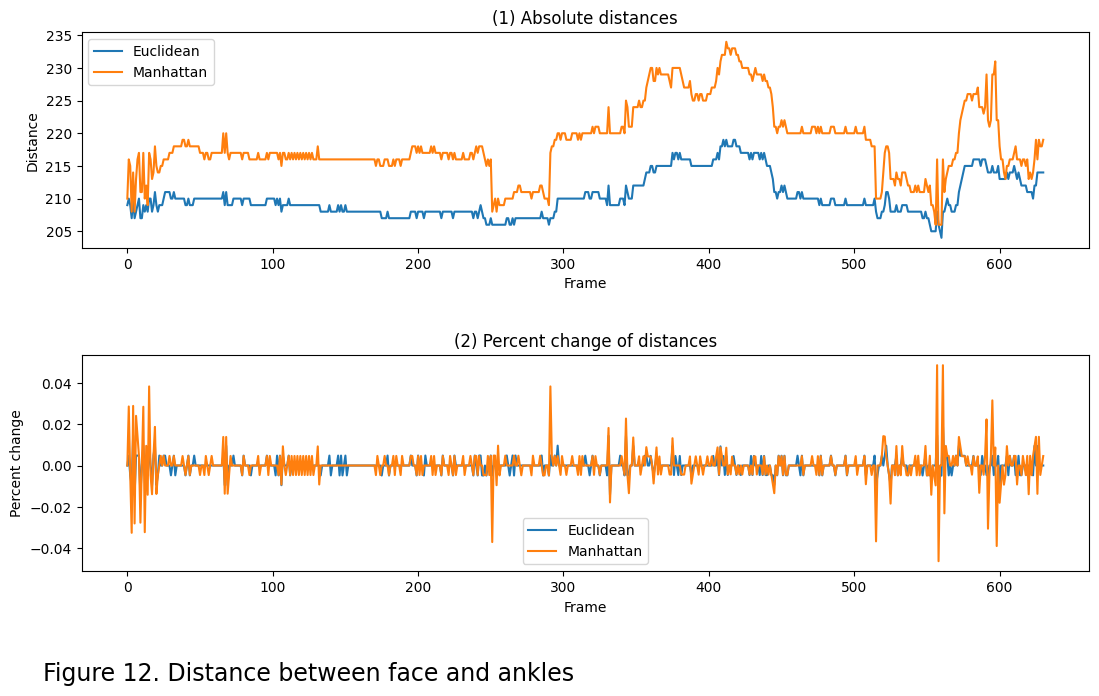

In [22]:
# Euclidean_face_to_ankle, 'Manhattan_face_to_ankle'
# 'p_change_Euclidean_face_to_ankle', 'p_change_Manhattan_face_to_right_hand', '',


fig,ax = plt.subplots(2,1)


print()
print()
fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 12. Distance between face and ankles',fontsize=17, x=0.3,y=-.02, ha='center')
fig.subplots_adjust(hspace=.5)
axes[0].plot(id_df['Frame'],id_df['Euclidean_face_to_ankle'],label='Euclidean')
axes[0].plot(id_df['Frame'],id_df['Manhattan_face_to_ankle'],label='Manhattan')
axes[0].set_title("(1) Absolute distances")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(id_df['Frame'],id_df['p_change_Euclidean_face_to_ankle'],label='Euclidean')
axes[1].plot(id_df['Frame'],id_df['p_change_Manhattan_face_to_ankle'],label='Manhattan')
axes[1].set_title("(2) Percent change of distances")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Percent change")




plt.show()


In [23]:
# id_df[['face_AppearanceRate','left_hand_AppearanceRate','right_hand_AppearanceRate','left_foot_AppearanceRate','right_foot_AppearanceRate']]

### Figure 13. Body Part Occurrences

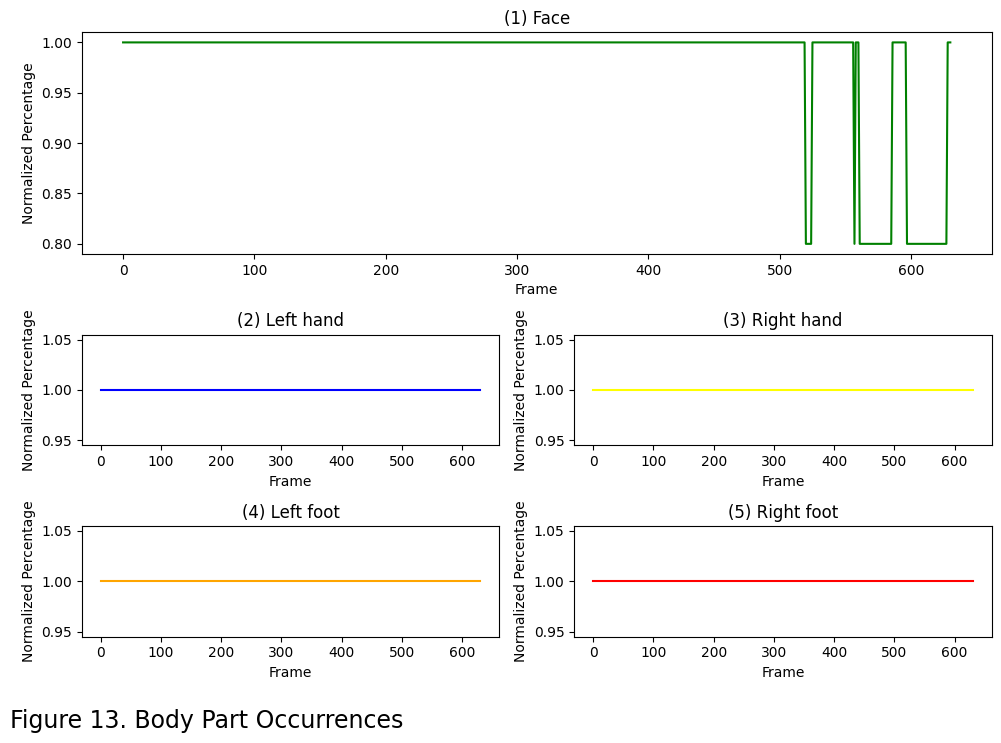

In [24]:
# 'face_AppearanceRate','left_hand_AppearanceRate','right_hand_AppearanceRate',
# 'left_foot_AppearanceRate','right_foot_AppearanceRate'


print()
print()

# Create a figure and a GridSpec for customizing subplots
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1])

# Create the first subplot (big)
ax1 = plt.subplot(gs[0, :])
ax1.plot(id_df['Frame'],id_df['face_AppearanceRate'],color='green')  # Example plot
ax1.set_title('(1) Face')
ax1.set_ylabel("Normalized Percentage")
ax1.set_xlabel("Frame")
# Create the second subplot (top-right)
ax2 = plt.subplot(gs[1, 0])
ax2.plot(id_df['Frame'],id_df['left_hand_AppearanceRate'],color='blue')  # Example plot
ax2.set_title('(2) Left hand')
ax2.set_ylabel("Normalized Percentage")
ax2.set_xlabel("Frame")

# Create the third subplot (bottom-left)
ax3 = plt.subplot(gs[1, 1])
ax3.plot(id_df['Frame'],id_df['right_hand_AppearanceRate'],color='yellow') # Example plot
ax3.set_title('(3) Right hand')
ax3.set_ylabel("Normalized Percentage")
ax3.set_xlabel("Frame")

# Create the fourth subplot (bottom-right)
ax4 = plt.subplot(gs[2, 0])
ax4.plot(id_df['Frame'],id_df['left_foot_AppearanceRate'],color='orange')  # Example plot
ax4.set_title('(4) Left foot')
ax4.set_ylabel("Normalized Percentage")
ax4.set_xlabel("Frame")

# Create the fifth subplot (bottom-right)
ax5 = plt.subplot(gs[2, 1])
ax5.plot(id_df['Frame'],id_df['right_foot_AppearanceRate'],color='red') # Example plot
ax5.set_title('(5) Right foot')
ax5.set_ylabel("Normalized Percentage")
ax5.set_xlabel("Frame")


plt.tight_layout()  # Adjust subplot parameters to give specified padding

fig.suptitle('Figure 13. Body Part Occurrences',fontsize=17, x=0.2,y=-.02, ha='center')

plt.show()


# By Frames

In [25]:
individul_metrics_df.columns

Index(['ID', 'Frame', 'Total_Mean_Pose_X', 'Total_Mean_Pose_Y',
       'pc_Total_Mean_Pose_X', 'pc_Total_Mean_Pose_Y', 'face_MeanPose_X',
       'face_MeanPose_Y', 'pc_face_MeanPose_X', 'pc_face_MeanPose_Y',
       'hand_MeanPose_X', 'hand_MeanPose_Y', 'pc_hand_MeanPose_X',
       'pc_hand_MeanPose_Y', 'foot_MeanPose_X', 'foot_MeanPose_Y',
       'pc_foot_MeanPose_X', 'pc_foot_MeanPose_Y', 'bbox_center_x',
       'bbox_center_y', 'bbox_area', 'p_changebbox_center_x',
       'p_changebbox_center_y', 'p_changebbox_area',
       'Euclidean_eye_to_shoulder', 'Manhattan_eye_to_shoulder',
       'p_change_Euclidean_eye_to_shoulder',
       'p_change_Manhattan_eye_to_shoulder', 'Euclidean_face_to_left_hand',
       'Manhattan_face_to_left_hand', 'p_change_Euclidean_face_to_left_hand',
       'p_change_Manhattan_face_to_left_hand', 'Euclidean_face_to_right_hand',
       'Manhattan_face_to_right_hand', 'p_change_Euclidean_face_to_right_hand',
       'p_change_Manhattan_face_to_right_hand', 'Euc

In [26]:
frame_df = individul_metrics_df.copy()

frame_df = frame_df[['Frame','ID','face_AppearanceRate',
                     'Euclidean_nose_to_left_shoulder','Manhattan_nose_to_left_shoulder',
                     'Euclidean_nose_to_right_shoulder', 'Manhattan_nose_to_right_shoulder',
                     'Euclidean_face_to_ankle','Manhattan_face_to_ankle' ]].drop_duplicates()

frame_df.sort_values("Frame",inplace=True)

frame_df = frame_df.drop("ID",axis=1).groupby("Frame").agg("mean")
frame_df_pc = frame_df.pct_change().add_prefix("p_change_").reset_index()

# frame_df_ma = frame_df.rolling(10).mean().reset_index().dropna()
frame_df.reset_index(inplace=True)
frame_df = frame_df.merge(frame_df_pc,on='Frame')



# frame_df.rename(columns={"index":'Frame'})

In [27]:
frame_df.head()

,Frame,face_AppearanceRate,Euclidean_nose_to_left_shoulder,Manhattan_nose_to_left_shoulder,Euclidean_nose_to_right_shoulder,Manhattan_nose_to_right_shoulder,Euclidean_face_to_ankle,Manhattan_face_to_ankle,p_change_face_AppearanceRate,p_change_Euclidean_nose_to_left_shoulder,p_change_Manhattan_nose_to_left_shoulder,p_change_Euclidean_nose_to_right_shoulder,p_change_Manhattan_nose_to_right_shoulder,p_change_Euclidean_face_to_ankle,p_change_Manhattan_face_to_ankle
0,0,0.914286,47.428571,63.857143,49.428571,68.428571,232.000000,250.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.914286,47.000000,63.428571,49.000000,67.714286,231.714286,251.000000,0.0,-0.009036,-0.006711,-0.008671,-0.010438,-0.001232,0.002854
2,2,0.914286,47.000000,63.428571,49.285714,68.142857,230.857143,250.285714,0.0,0.000000,0.000000,0.005831,0.006329,-0.003699,-0.002846
3,3,0.914286,47.428571,63.571429,49.142857,67.714286,230.285714,249.142857,0.0,0.009119,0.002252,-0.002899,-0.006289,-0.002475,-0.004566
4,4,0.914286,47.142857,63.428571,48.857143,67.428571,231.000000,249.857143,0.0,-0.006024,-0.002247,-0.005814,-0.004219,0.003102,0.002867


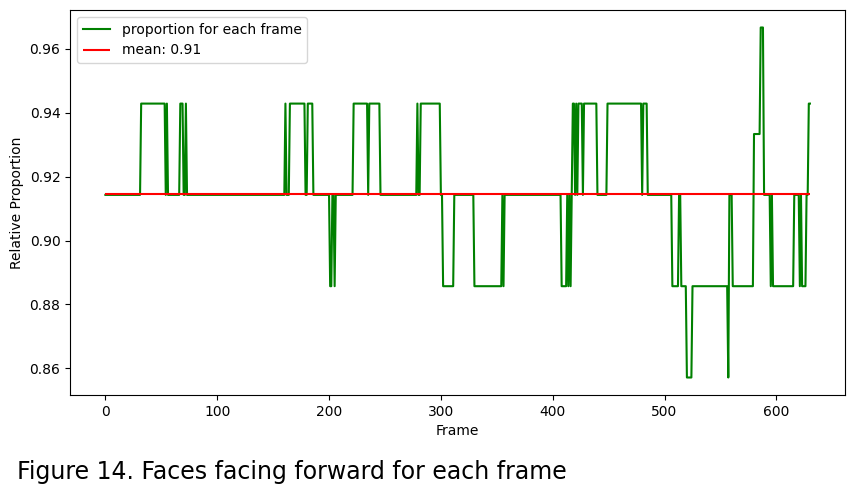

In [28]:

print()
print()
fig,ax = plt.subplots(1,1)

fig.set_figwidth(10)
fig.set_figheight(5)


appear_mean = frame_df['face_AppearanceRate'].mean()

ax.plot(frame_df['Frame'],frame_df['face_AppearanceRate'],color='green',label='proportion for each frame')
ax.hlines(appear_mean,0,frame_df['Frame'].max(),color='red',label=f'mean: {round(appear_mean,2)}')
ax.set_xlabel("Frame")
ax.set_ylabel("Relative Proportion")
ax.legend()

fig.suptitle('Figure 14. Faces facing forward for each frame ',fontsize=17, x=0.35,y=-.02, ha='center')

plt.show()


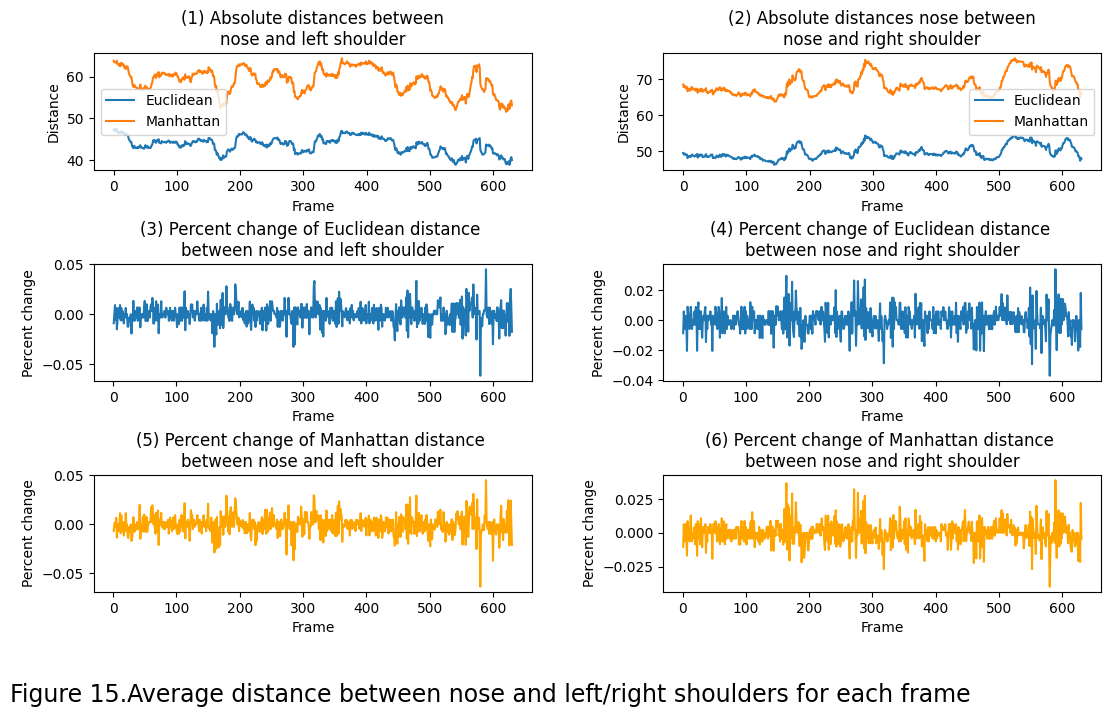

In [29]:
# Euclidean_nose_to_left_shoulder, Manhattan_nose_to_left_shoulder,
# Euclidean_nose_to_right_shoulder, Manhattan_nose_to_right_shoulder

# p_change_Euclidean_nose_to_left_shoulder, p_change_Manhattan_nose_to_left_shoulder
# p_change_Euclidean_nose_to_right_shoulder, p_change_Manhattan_nose_to_right_shoulder
print()
print()
fig,ax = plt.subplots(3,2)


fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 15.Average distance between nose and left/right shoulders for each frame',fontsize=17, x=0.43,y=-.02, ha='center')
fig.subplots_adjust(hspace=.8,wspace=.3)


axes[0].plot(frame_df['Frame'],frame_df['Euclidean_nose_to_left_shoulder'],label='Euclidean')
axes[0].plot(frame_df['Frame'],frame_df['Manhattan_nose_to_left_shoulder'],label='Manhattan')
axes[0].set_title("(1) Absolute distances between\nnose and left shoulder")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(frame_df['Frame'],frame_df['Euclidean_nose_to_right_shoulder'],label='Euclidean')
axes[1].plot(frame_df['Frame'],frame_df['Manhattan_nose_to_right_shoulder'],label='Manhattan')
axes[1].set_title("(2) Absolute distances nose between\nnose and right shoulder")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Distance")


axes[2].plot(frame_df['Frame'],frame_df['p_change_Euclidean_nose_to_left_shoulder'])
axes[2].set_title("(3) Percent change of Euclidean distance \nbetween nose and left shoulder")
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Percent change")


axes[3].plot(frame_df['Frame'],frame_df['p_change_Euclidean_nose_to_right_shoulder'])
axes[3].set_title("(4) Percent change of Euclidean distance \nbetween nose and right shoulder")
axes[3].set_xlabel("Frame")
axes[3].set_ylabel("Percent change")


axes[4].plot(frame_df['Frame'],frame_df['p_change_Manhattan_nose_to_left_shoulder'],color='Orange')
axes[4].set_title("(5) Percent change of Manhattan distance \nbetween nose and left shoulder")
axes[4].set_xlabel("Frame")
axes[4].set_ylabel("Percent change")


axes[5].plot(frame_df['Frame'],frame_df['p_change_Manhattan_nose_to_right_shoulder'],color='Orange')
axes[5].set_title("(6) Percent change of Manhattan distance \nbetween nose and right shoulder")
axes[5].set_xlabel("Frame")
axes[5].set_ylabel("Percent change")


plt.show()


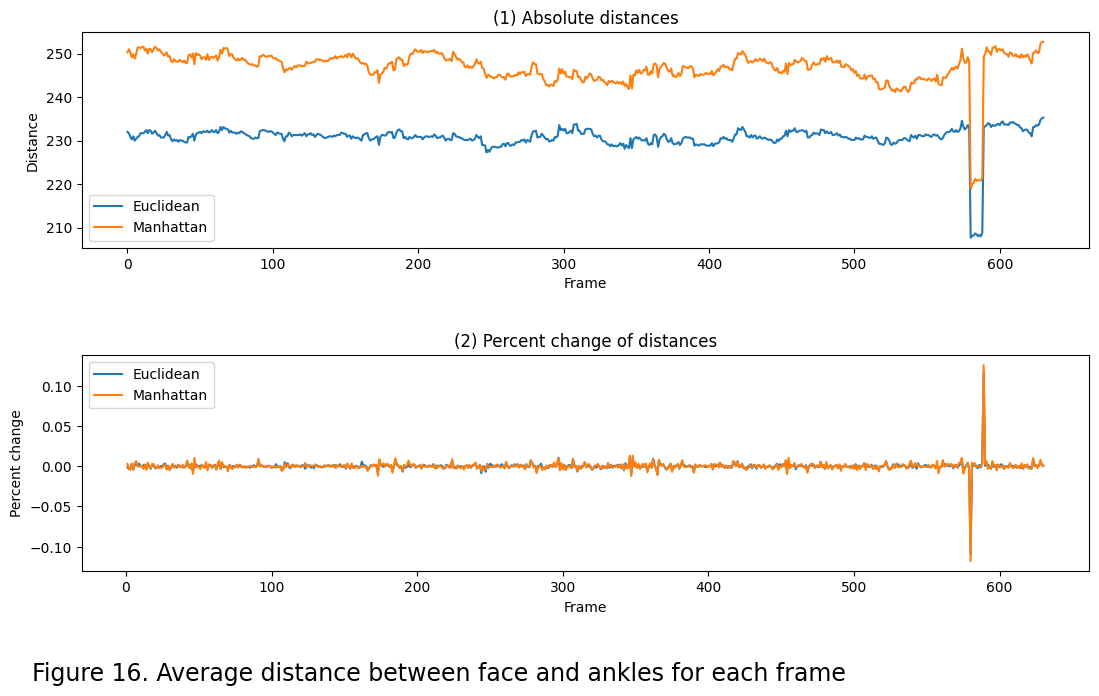

In [30]:
# Euclidean_face_to_ankle, 'Manhattan_face_to_ankle'
# 'p_change_Euclidean_face_to_ankle', 'p_change_Manhattan_face_to_right_hand', '',


fig,ax = plt.subplots(2,1)


print()
print()
fig.set_figheight(7)
fig.set_figwidth(13)
axes = ax.flatten()



fig.suptitle('Figure 16. Average distance between face and ankles for each frame',fontsize=17, x=0.4,y=-.02, ha='center')
fig.subplots_adjust(hspace=.5)
axes[0].plot(frame_df['Frame'],frame_df['Euclidean_face_to_ankle'],label='Euclidean')
axes[0].plot(frame_df['Frame'],frame_df['Manhattan_face_to_ankle'],label='Manhattan')
axes[0].set_title("(1) Absolute distances")
axes[0].legend()
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Distance")


axes[1].plot(frame_df['Frame'],frame_df['p_change_Euclidean_face_to_ankle'],label='Euclidean')
axes[1].plot(frame_df['Frame'],frame_df['p_change_Manhattan_face_to_ankle'],label='Manhattan')
axes[1].set_title("(2) Percent change of distances")
axes[1].legend()
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Percent change")




plt.show()


# For each id

In [31]:
individul_metrics_df.columns

Index(['ID', 'Frame', 'Total_Mean_Pose_X', 'Total_Mean_Pose_Y',
       'pc_Total_Mean_Pose_X', 'pc_Total_Mean_Pose_Y', 'face_MeanPose_X',
       'face_MeanPose_Y', 'pc_face_MeanPose_X', 'pc_face_MeanPose_Y',
       'hand_MeanPose_X', 'hand_MeanPose_Y', 'pc_hand_MeanPose_X',
       'pc_hand_MeanPose_Y', 'foot_MeanPose_X', 'foot_MeanPose_Y',
       'pc_foot_MeanPose_X', 'pc_foot_MeanPose_Y', 'bbox_center_x',
       'bbox_center_y', 'bbox_area', 'p_changebbox_center_x',
       'p_changebbox_center_y', 'p_changebbox_area',
       'Euclidean_eye_to_shoulder', 'Manhattan_eye_to_shoulder',
       'p_change_Euclidean_eye_to_shoulder',
       'p_change_Manhattan_eye_to_shoulder', 'Euclidean_face_to_left_hand',
       'Manhattan_face_to_left_hand', 'p_change_Euclidean_face_to_left_hand',
       'p_change_Manhattan_face_to_left_hand', 'Euclidean_face_to_right_hand',
       'Manhattan_face_to_right_hand', 'p_change_Euclidean_face_to_right_hand',
       'p_change_Manhattan_face_to_right_hand', 'Euc

In [32]:
draft_id = df_not_zero[df_not_zero['ID'] == 1][['Frame','KeyLandmark','Pose_X','Pose_Y']].copy()

In [33]:
draft_id.head()

,Frame,KeyLandmark,Pose_X,Pose_Y
0,0,face,344,286
1,0,face,351,281
2,0,face,337,279
3,0,face,359,285
4,0,face,324,282


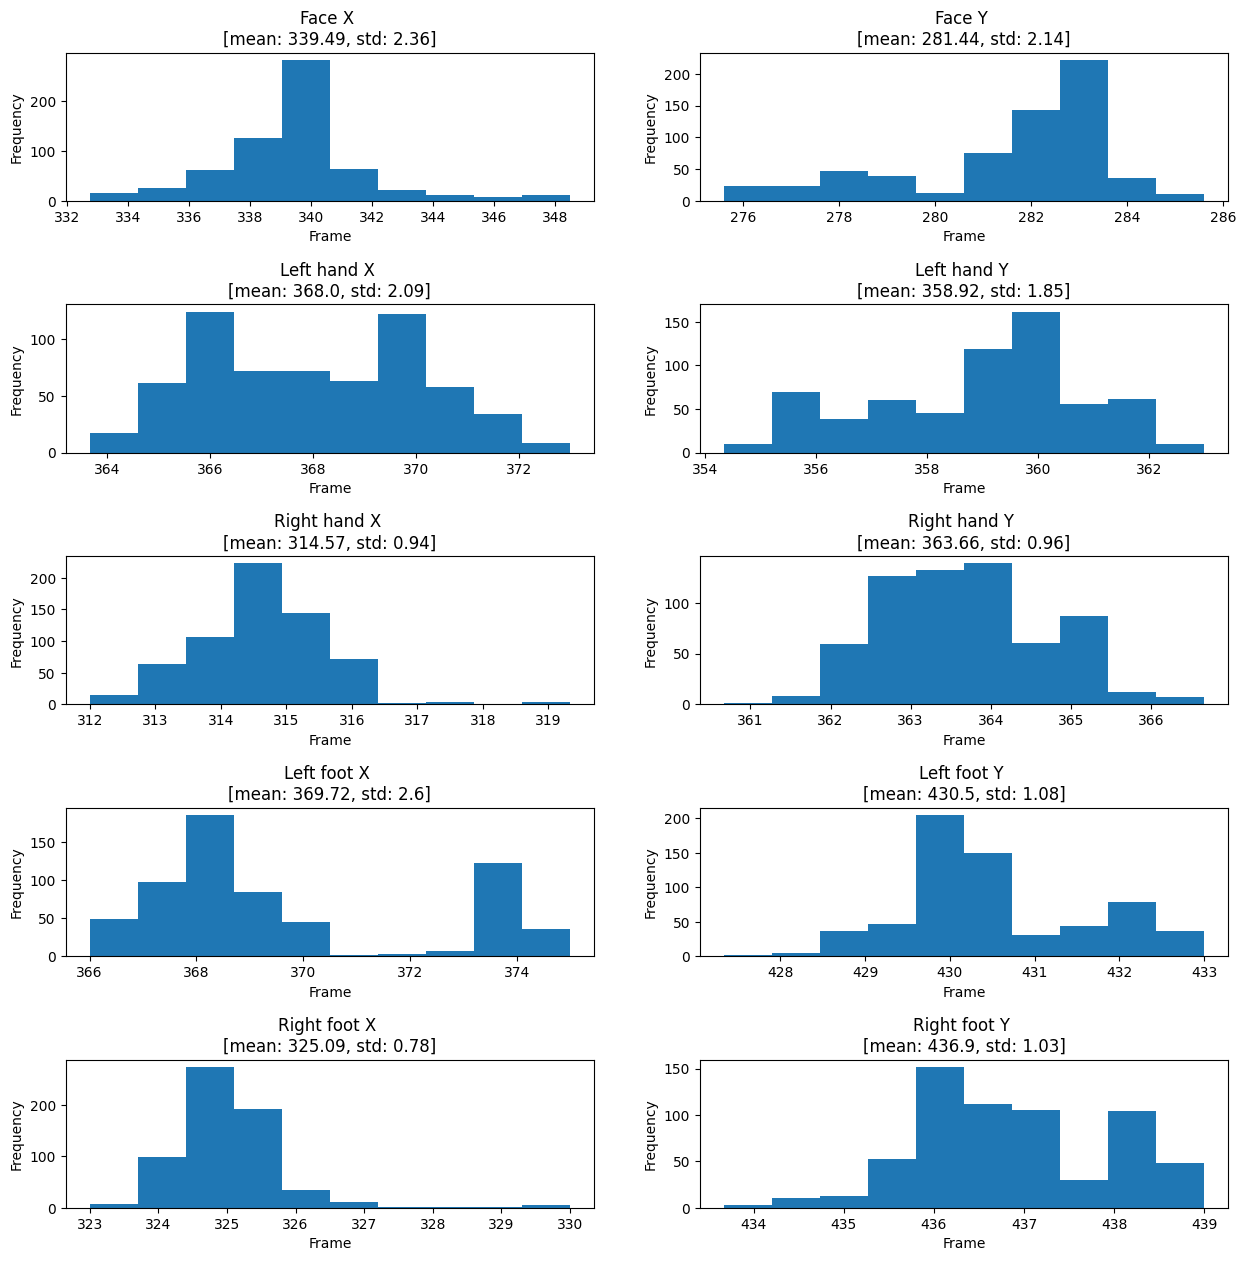

In [34]:

# fig = plt.figure(figsize=(10, 12))
# gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1])

fig,ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=.7)

axes = ax.flatten()

i = 0

max_x,max_y, _ = orig_image_shape

for land in draft_id.KeyLandmark.unique():

    land_df = draft_id[draft_id['KeyLandmark'] == land].copy()
    land_df = land_df.groupby(['KeyLandmark','Frame'],as_index=False).mean()

    pose_x = land_df['Pose_X']
    pose_y = land_df['Pose_Y']

    mean_pose_x = round(np.mean(pose_x),2)
    mean_pose_y = round(np.mean(pose_y),2)

    std_pose_x = round(np.std(pose_x),2)
    std_pose_y = round(np.std(pose_y),2)
    
    title = land.replace("_"," ").capitalize()
    axes[i].hist(pose_x)
    axes[i].set_title(f"{title} X \n[mean: {mean_pose_x}, std: {std_pose_x}]")
    axes[i].set_xlabel("Frame")
    axes[i].set_ylabel("Frequency")
    # axes[i].legend()
    i+=1
    
    axes[i].hist(pose_y)
    axes[i].set_title(f"{title} Y \n[mean: {mean_pose_y}, std: {std_pose_y}]")
    axes[i].set_xlabel("Frame")
    axes[i].set_ylabel("Frequency")
    i+=1
    
    
plt.show()

In [35]:
for_each_id = individul_metrics_df.copy()

for_each_id = for_each_id[['ID','Frame','face_AppearanceRate']]

for_each_id = for_each_id.groupby("ID",as_index=False)['face_AppearanceRate'].mean()
for_each_id['ID'] = for_each_id['ID'].astype(str)
for_each_id.sort_values("face_AppearanceRate",inplace=True)

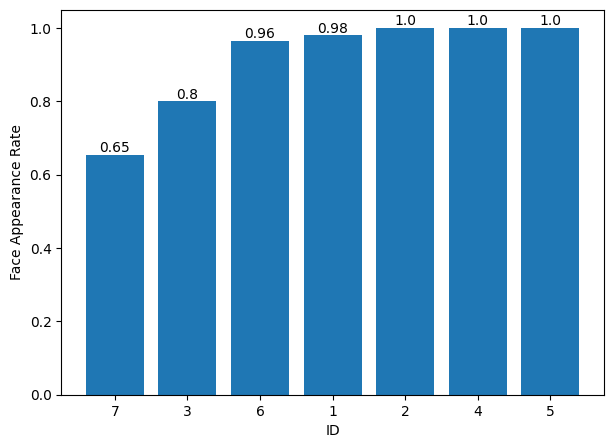

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
# Assuming 'for_each_id' is a DataFrame with columns 'ID' and 'face_AppearanceRate'
plt.bar(for_each_id['ID'], for_each_id['face_AppearanceRate'])

# Add annotations
for i, rate in enumerate(for_each_id['face_AppearanceRate']):
    plt.text(i, rate, f'{round(rate,2)}', ha='center', va='bottom')

plt.xlabel('ID')
plt.ylabel('Face Appearance Rate')
# plt.title('Bar Plot with Annotations')

plt.show()
